In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# ***`Libraries`***

In [1]:
!pip install --upgrade mlxtend
!pip install kmodes
!pip install gower
!pip install scikit-learn
!pip install --upgrade jax jaxlib
!pip install scipy


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 36.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.3/87.3 MB 10.3 MB/s eta 0:00:00
  Attempting uninstall: jaxlib
    Found existing installation: jaxlib 0.4.33
    Uninstalling jaxlib-0.4.33:
      Successfully uninstalled jaxlib-0.4.33
  Attempting uninstall: jax
    Found existing installation: jax 0.4.33
    Uninstalling jax-0.4.33:
      Successfully uninstalled jax-0.4.33


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler, KBinsDiscretizer, OneHotEncoder
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from yellowbrick.cluster import SilhouetteVisualizer, KElbowVisualizer
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from scipy.spatial.distance import cdist
from sklearn.mixture import GaussianMixture
from kmodes.kprototypes import KPrototypes
import scipy.cluster.hierarchy as sch
import gower
from scipy.stats.mstats import winsorize
import matplotlib.pyplot as plt

In [3]:
  import warnings
  warnings.filterwarnings("ignore")

# ***`EDA`***

In [5]:
df_cleaned = pd.read_excel('/content/drive/My Drive/Colab Notebooks/NCKH (Ph. Danh Hường)/Data thô/data_cleaned.xlsx')
df_cleaned.head(2)

,Name_Shop,revenue,positive,negative,total_feedback,Year_Joined,Shop_Rating,Counter_Rating,Followers,Chat Resopnse
0,2N Unisex,1326000,233,46,279,5,4.7,1100,982,0
1,3M Automotive Official,25545495,312,104,416,4,4.7,1400,1500,0


In [6]:
null_values = df_cleaned.isnull().sum()
print(null_values)

Name_Shop         0
revenue           0
positive          0
negative          0
total_feedback    0
Year_Joined       0
Shop_Rating       0
Counter_Rating    0
Followers         0
Chat Resopnse     0
dtype: int64


In [7]:
df_cleaned['Chat Resopnse'] = df_cleaned['Chat Resopnse'] / 100
df_cleaned = df_cleaned.drop(columns=['Name_Shop'])
df_cleaned['Year_Joined'] = df_cleaned['Year_Joined'].replace(0, 1)
df_cleaned = df_cleaned[df_cleaned['Counter_Rating'] != 0]

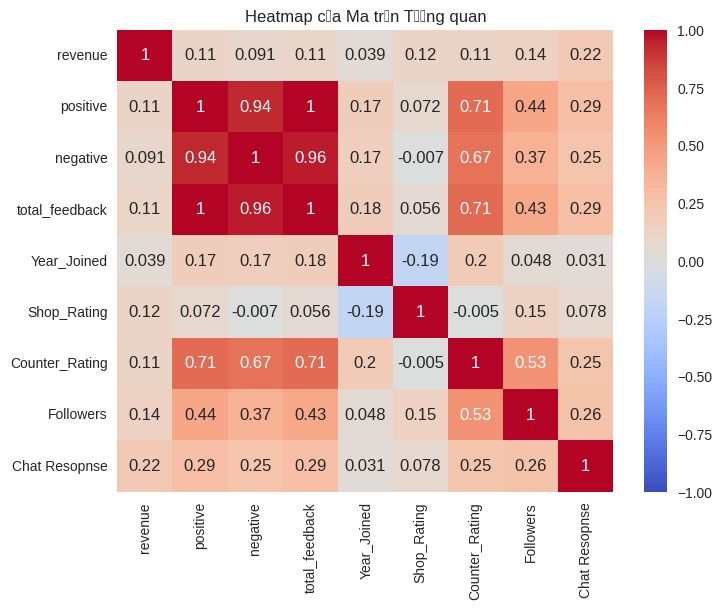

In [8]:
# Tính toán ma trận tương quan
correlation_matrix = df_cleaned.corr()

# Vẽ heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Heatmap của Ma trận Tương quan")
plt.show()

# ***`Wilson score interval`***

In [9]:
import pandas as pd
import numpy as np
from scipy.stats import norm

# Giả sử bạn có DataFrame df với các cột Shop_Rating và Counter_Rating
# Xác định z cho mức độ tin cậy mong muốn (95% confidence level)
z = norm.ppf(0.975)  # z = 1.96 cho mức độ tin cậy 95%

# Hàm tính điểm Wilson
def wilson_score(average_rating, total_ratings, z=z):
    p_hat = average_rating / 5  # Chuyển đổi Shop_Rating thành tỷ lệ giữa 0 và 1
    denominator = 1 + z**2 / total_ratings
    center_adjusted_probability = p_hat + z**2 / (2 * total_ratings)
    adjusted_standard_deviation = z * np.sqrt((p_hat * (1 - p_hat) + z**2 / (4 * total_ratings)) / total_ratings)
    wilson_lower_bound = (center_adjusted_probability - adjusted_standard_deviation) / denominator
    return wilson_lower_bound * 5  # Quy đổi về thang 5 sao

# Áp dụng hàm vào cột mới 'Wilson_Score' trong DataFrame
# Thay đổi ở đây: Truyền các giá trị của từng hàng vào hàm wilson_score
df_cleaned['Rating_quality'] = df_cleaned.apply(lambda x: wilson_score(x['Shop_Rating'], x['Counter_Rating']), axis=1)

In [10]:
import pandas as pd
import numpy as np
from scipy.stats import norm

# Giả sử bạn có DataFrame df với các cột positive, negative, total_feedback
# Xác định z cho mức độ tin cậy mong muốn (95% confidence level)
z = norm.ppf(0.975)  # z = 1.96 cho mức độ tin cậy 95%

# Hàm tính điểm Wilson
def wilson_score(positive, total_feedback, z=z):
    if total_feedback == 0:
        return 0  # Trả về 0 nếu không có feedback nào
    p_hat = positive / total_feedback  # Tỷ lệ tích cực
    denominator = 1 + z**2 / total_feedback
    center_adjusted_probability = p_hat + z**2 / (2 * total_feedback)
    adjusted_standard_deviation = z * np.sqrt((p_hat * (1 - p_hat) + z**2 / (4 * total_feedback)) / total_feedback)
    wilson_lower_bound = (center_adjusted_probability - adjusted_standard_deviation) / denominator
    return wilson_lower_bound

# Áp dụng hàm vào cột mới 'Wilson_Score_Positive' trong DataFrame
df_cleaned['Positive_quality'] = df_cleaned.apply(lambda x: wilson_score(x['positive'], x['total_feedback']), axis=1)
# df_cleaned['Negative_quality'] = df_cleaned.apply(lambda x: wilson_score(x['negative'], x['total_feedback']), axis=1)

In [11]:
df_cleaned = df_cleaned.drop(columns=['positive', 'negative', 'total_feedback', 'Shop_Rating', 'Counter_Rating'])

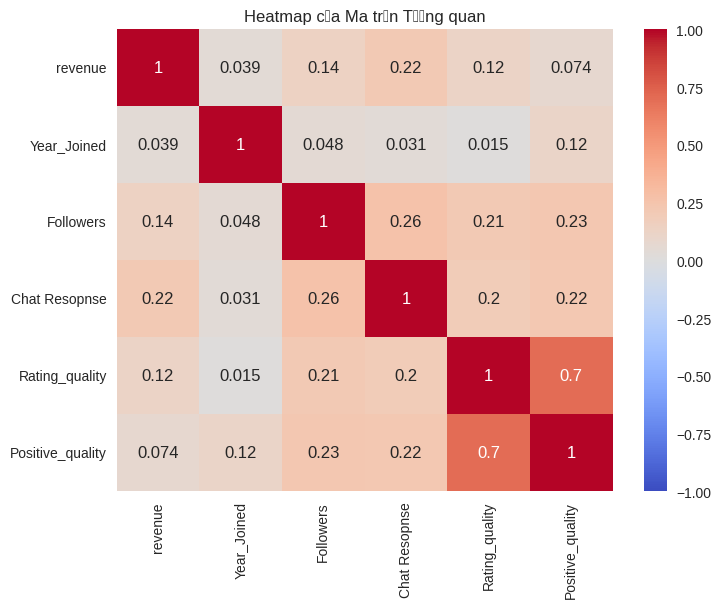

In [12]:
# Tính toán ma trận tương quan
correlation_matrix = df_cleaned.corr()

# Vẽ heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Heatmap của Ma trận Tương quan")
plt.show()

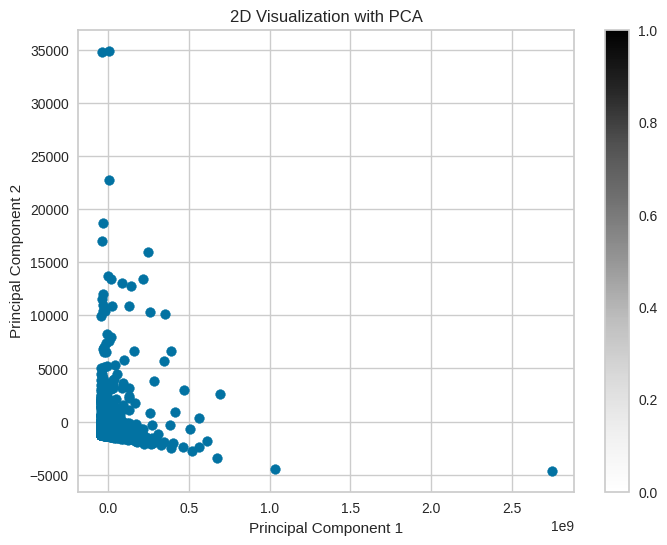

In [13]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Giả sử bạn có dữ liệu nhiều chiều trong X
# Sử dụng PCA để giảm xuống còn 2 thành phần
pca = PCA(n_components=2)
X_pca = pca.fit_transform(df_cleaned)

# Trực quan hóa dữ liệu
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], cmap='viridis')  # Thay labels bằng nhãn cụm nếu có
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('2D Visualization with PCA')
plt.colorbar()
plt.show()


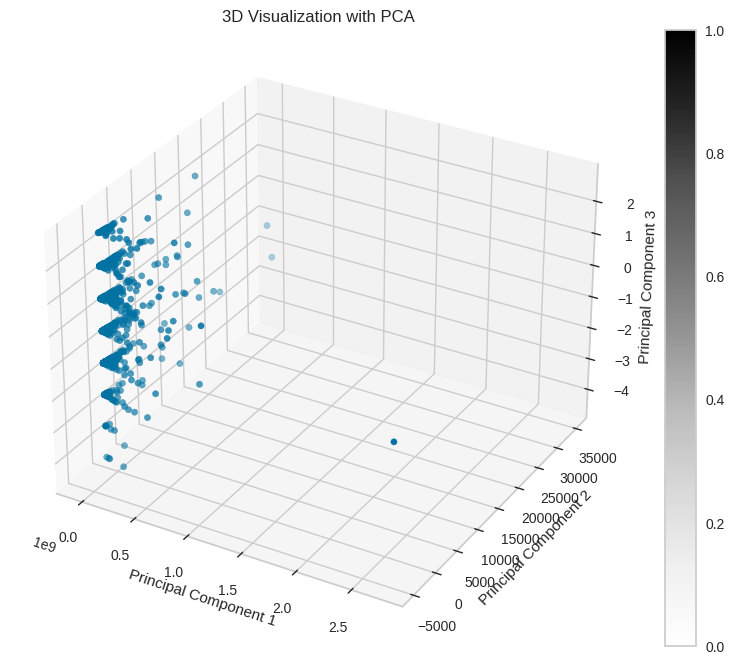

In [14]:
# Giả sử bạn có dữ liệu nhiều chiều trong X
# Sử dụng PCA để giảm xuống còn 3 thành phần
pca = PCA(n_components=3)
X_pca = pca.fit_transform(df_cleaned)

# Trực quan hóa dữ liệu trong không gian 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

sc = ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], cmap='viridis')  # Replace 'labels' with your data labels or clustering results
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
plt.title('3D Visualization with PCA')
plt.colorbar(sc)
plt.show()

# ***`Describe`***

In [15]:
df_copy_temp =  df_cleaned.copy()
df_copy_temp.describe()

,revenue,Year_Joined,Followers,Chat Resopnse,Rating_quality,Positive_quality
count,9.330000e+02,933.000000,933.000000,933.000000,933.000000,933.000000
mean,4.443773e+07,5.403001,1407.422294,0.349400,4.390583,0.678008
std,1.319756e+08,1.442931,2965.526020,0.426577,0.447215,0.149187
min,0.000000e+00,1.000000,1.000000,0.000000,0.472656,0.000000
25%,1.712999e+06,4.000000,140.000000,0.000000,4.296420,0.641034
50%,7.390000e+06,6.000000,479.000000,0.000000,4.493360,0.715368
75%,2.980900e+07,7.000000,1395.000000,0.830000,4.638440,0.771763
max,2.792880e+09,8.000000,36317.000000,1.000000,4.963264,0.927649


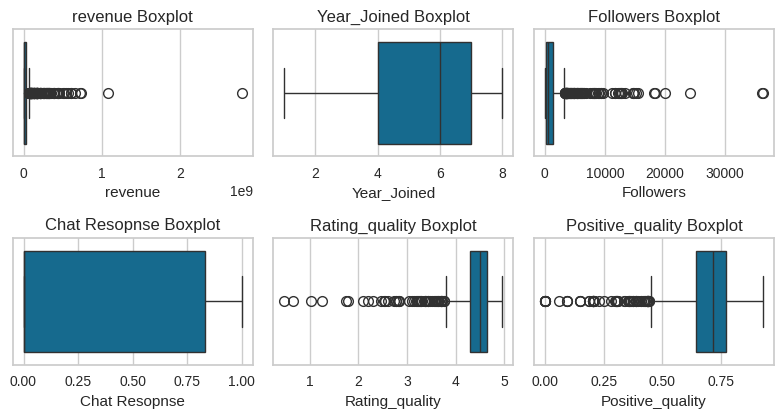

In [16]:
# Visualize the boxplot of each variable.
plt.figure(figsize=(8, 6))
for i, j in enumerate(df_copy_temp.describe().columns):
    plt.subplot(3,3, i+1)
    sns.boxplot(x=df_copy_temp[j])
    plt.title('{} Boxplot'.format(j))
    plt.tight_layout()

plt.show()

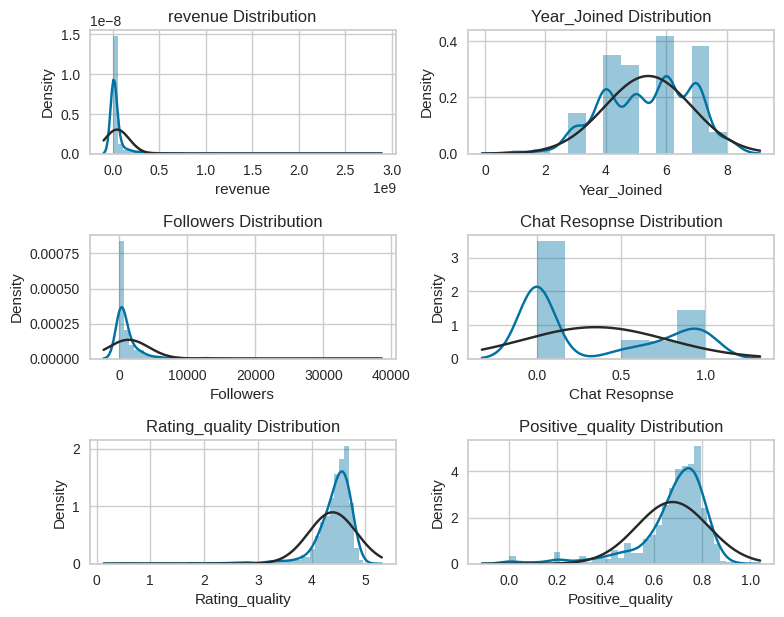

In [17]:
import scipy.stats as stats

# Visualize the distribution of each variable.
plt.figure(figsize=(8, 10))
for i, j in enumerate(df_copy_temp.describe().columns):
    plt.subplot(5,2, i+1)
    sns.distplot(x=df_copy_temp[j], fit = stats.norm)
    plt.xlabel(j)
    plt.title('{} Distribution'.format(j))
    plt.tight_layout()
plt.show()

# ***`Z-Score`***

In [18]:
# Khởi tạo StandardScaler
scaler = StandardScaler()

# Chuẩn hóa dữ liệu
scaled_data = scaler.fit_transform(df_copy_temp)
scaled_df = pd.DataFrame(scaled_data, columns=df_copy_temp.columns)

In [19]:
scaled_df

,revenue,Year_Joined,Followers,Chat Resopnse,Rating_quality,Positive_quality
0,-0.326840,-0.279443,-0.143533,-0.819518,0.517466,0.731572
1,-0.143226,-0.972848,0.031235,-0.819518,0.539159,0.189270
2,-0.260906,0.413962,3.475303,1.525984,0.663007,1.122368
3,-0.313024,1.107368,-0.313240,-0.819518,-0.090066,0.500853
4,-0.287069,0.413962,-0.284224,1.525984,0.379822,0.768611
...,...,...,...,...,...,...
928,0.292289,-0.972848,-0.408721,1.525984,-0.349262,-0.545265
929,0.176205,-0.279443,0.581516,1.314889,0.410154,0.269981
930,-0.203387,-1.666254,-0.183682,1.361799,0.353820,0.214836
931,0.701569,-1.666254,1.329508,-0.819518,0.160550,0.487386


# ***`Winsorization `***

In [20]:
columns_to_winsorize = ['revenue', 'Followers', 'Rating_quality', 'Positive_quality']

for col in columns_to_winsorize:
    scaled_df[col] = winsorize(scaled_df[col], limits=[0.05, 0.05])

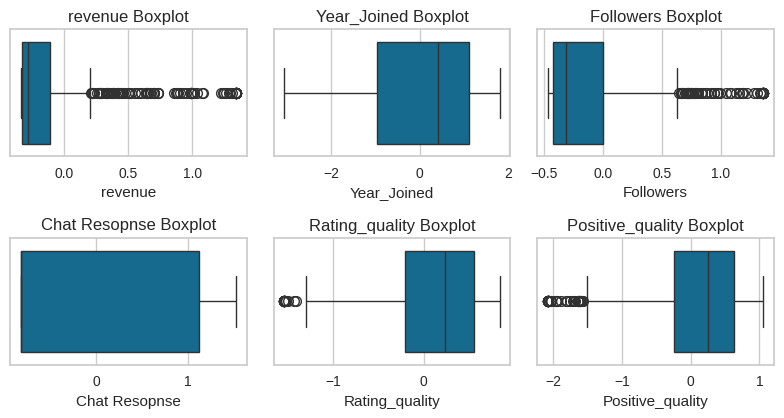

In [21]:
# Visualize the boxplot of each variable.
plt.figure(figsize=(8, 6))
for i, j in enumerate(scaled_df.columns):
    plt.subplot(3,3, i+1)
    sns.boxplot(x=scaled_df[j])
    plt.title('{} Boxplot'.format(j))
    plt.tight_layout()

plt.show()

# ***`Isolation Forest`***

In [22]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.ensemble import IsolationForest # Import IsolationForest from sklearn.ensemble

# Áp dụng Isolation Forest với contamination=0.1
iso_forest = IsolationForest(contamination=0.08, random_state=42)
outlier_pred = iso_forest.fit_predict(scaled_df)

# Lọc ra các điểm không phải outlier
inliers_df = scaled_df[outlier_pred == 1]

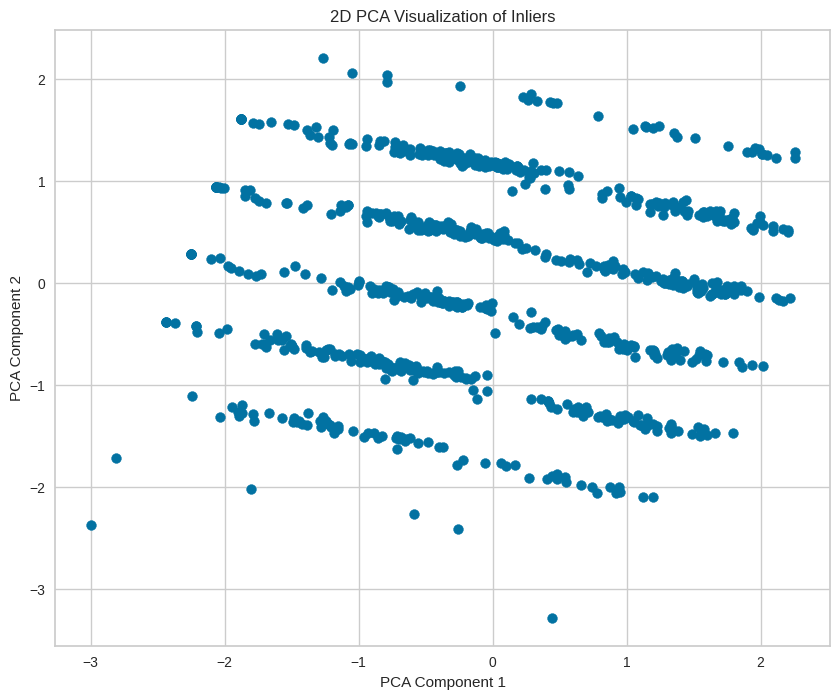

In [23]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Áp dụng PCA để giảm số chiều xuống 2
pca = PCA(n_components=2)
inliers_pca_2d = pca.fit_transform(inliers_df)

# Vẽ biểu đồ phân tán 2D
plt.figure(figsize=(10, 8))
plt.scatter(inliers_pca_2d[:, 0], inliers_pca_2d[:, 1], c='b', marker='o', s=50)

# Gán nhãn cho các trục
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('2D PCA Visualization of Inliers')

plt.show()


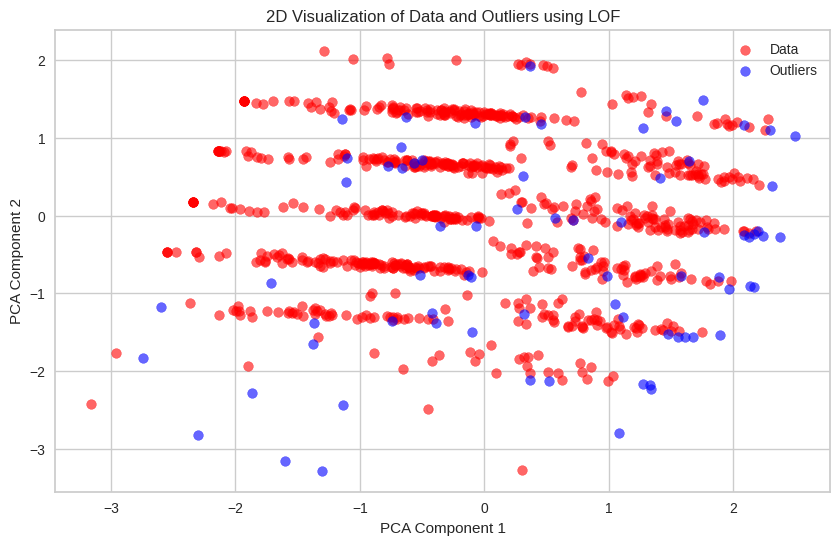

In [24]:
# Sử dụng PCA để giảm xuống 2 chiều để hiển thị
pca_2d = PCA(n_components=2, random_state=42)
df_pca_2d = pca_2d.fit_transform(scaled_df)

# Phân loại dữ liệu và outliers cho 2D (sử dụng LOF như yêu cầu cuối cùng)
df_pca_2d_data_lof = df_pca_2d[outlier_pred == 1]    # Các điểm bình thường
df_pca_2d_outliers_lof = df_pca_2d[outlier_pred == -1]  # Các outliers

# Visualize dữ liệu trong không gian 2D với LOF
plt.figure(figsize=(10, 6))
plt.scatter(df_pca_2d_data_lof[:, 0], df_pca_2d_data_lof[:, 1], color='red', label="Data", alpha=0.6)
plt.scatter(df_pca_2d_outliers_lof[:, 0], df_pca_2d_outliers_lof[:, 1], color='blue', label="Outliers", alpha=0.6)
plt.title("2D Visualization of Data and Outliers using LOF")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()
plt.show()


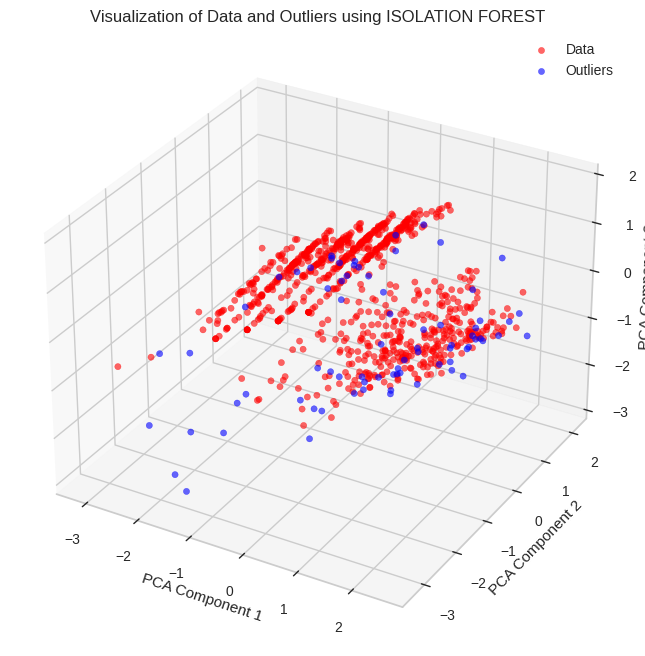

In [25]:
# Sử dụng PCA để giảm xuống 3 chiều để hiển thị
pca_3d = PCA(n_components=3, random_state=42)
df_pca_3d = pca_3d.fit_transform(scaled_df)

# Phân loại dữ liệu và outliers cho 3D (sử dụng LOF như yêu cầu cuối cùng)
df_pca_3d_data_lof = df_pca_3d[outlier_pred == 1]    # Các điểm bình thường
df_pca_3d_outliers_lof = df_pca_3d[outlier_pred == -1]  # Các outliers

# Visualize dữ liệu trong không gian 3D với LOF
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df_pca_3d_data_lof[:, 0], df_pca_3d_data_lof[:, 1], df_pca_3d_data_lof[:, 2],
           color='red', label="Data", alpha=0.6)
ax.scatter(df_pca_3d_outliers_lof[:, 0], df_pca_3d_outliers_lof[:, 1], df_pca_3d_outliers_lof[:, 2],
           color='blue', label="Outliers", alpha=0.6)
ax.set_title("Visualization of Data and Outliers using ISOLATION FOREST")
ax.set_xlabel("PCA Component 1")
ax.set_ylabel("PCA Component 2")
ax.set_zlabel("PCA Component 3")
ax.legend()
plt.show()

# ***`DBSCAN`***

In [26]:
inliers_df.head(2)

,revenue,Year_Joined,Followers,Chat Resopnse,Rating_quality,Positive_quality
0,-0.326840,-0.279443,-0.143533,-0.819518,0.517466,0.731572
1,-0.143226,-0.972848,0.031235,-0.819518,0.539159,0.189270


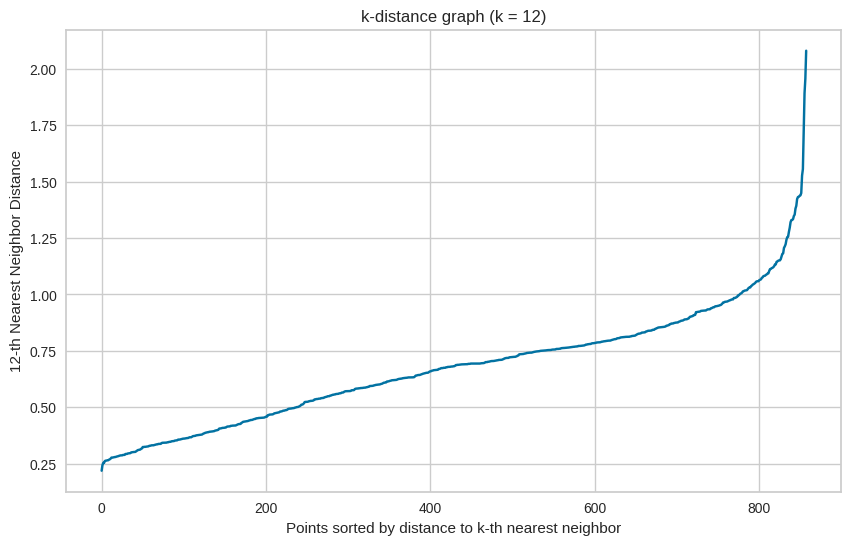

In [27]:
import numpy as np
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

X = inliers_df

# Bước 1: Chọn giá trị min_samples (minpts) - thường là 5 hoặc 10 tùy thuộc vào dữ liệu
min_samples = 12  # Giá trị thử nghiệm

# Bước 2: Tính toán khoảng cách đến min_samples lân cận gần nhất
neighbors = NearestNeighbors(n_neighbors=min_samples)
neighbors_fit = neighbors.fit(X)
distances, indices = neighbors_fit.kneighbors(X)

# Sắp xếp các khoảng cách để tìm "góc gãy" trên đồ thị
distances = np.sort(distances[:, min_samples - 1])  # Chọn khoảng cách đến điểm lân cận thứ min_samples

# Bước 3: Vẽ đồ thị k-distance graph
plt.figure(figsize=(10, 6))
plt.plot(distances)
plt.title(f'k-distance graph (k = {min_samples})')
plt.xlabel("Points sorted by distance to k-th nearest neighbor")
plt.ylabel(f"{min_samples}-th Nearest Neighbor Distance")
plt.grid(True)
plt.show()


In [28]:
dbscan = DBSCAN(eps=1.25, min_samples=12)
dbscan_labels = dbscan.fit_predict(X)

# Count the number of clusters and noise points
unique_labels, counts = np.unique(dbscan_labels, return_counts=True)
clusters_info = dict(zip(unique_labels, counts))

clusters_info

{-1: 3, 0: 855}

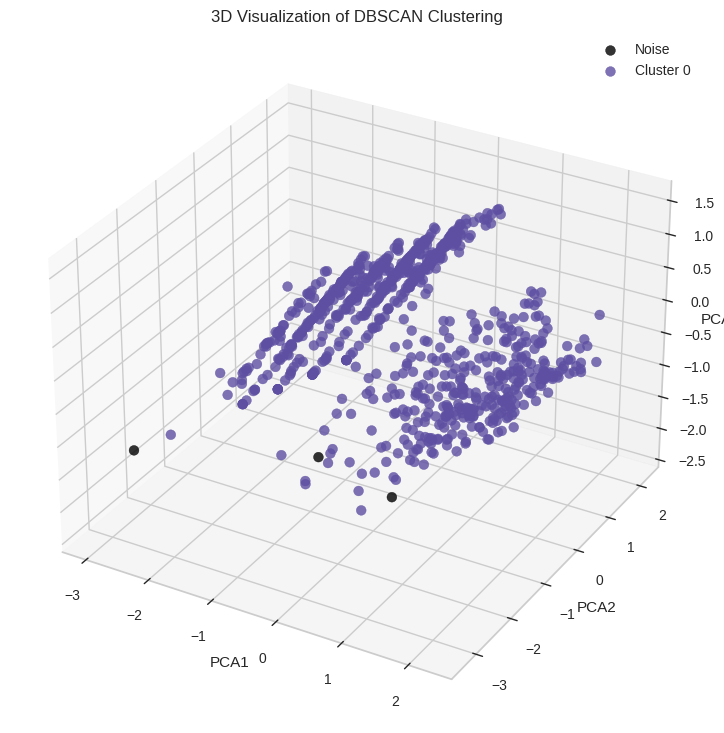

In [34]:
from sklearn.decomposition import PCA
pca_3d = PCA(n_components=3)  # Initialize PCA with 3 components
inliers_pca_3d = pca_3d.fit_transform(inliers_df)

plt.figure(figsize=(12, 9))
ax = plt.axes(projection='3d')

# Generate a list of colors for unique labels
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(np.unique(dbscan_labels)))]

for label, color in zip(np.unique(dbscan_labels), colors):
    if label == -1:  # Noise
        color = [0, 0, 0, 1]  # Black for noise
        label_name = "Noise"
    else:
        label_name = f"Cluster {label}"

    # Filter points belonging to the current cluster
    cluster_points = inliers_pca_3d[dbscan_labels == label]

    ax.scatter(cluster_points[:, 0], cluster_points[:, 1], cluster_points[:, 2],
               c=[color], label=label_name, s=50, alpha=0.8)

# Customize the plot
ax.set_title("3D Visualization of DBSCAN Clustering")
ax.set_xlabel("PCA1")
ax.set_ylabel("PCA2")
ax.set_zlabel("PCA3")
ax.legend(loc="best")
plt.show()

In [30]:
non_noise_mask = dbscan_labels != -1
X_non_noise = X[non_noise_mask]

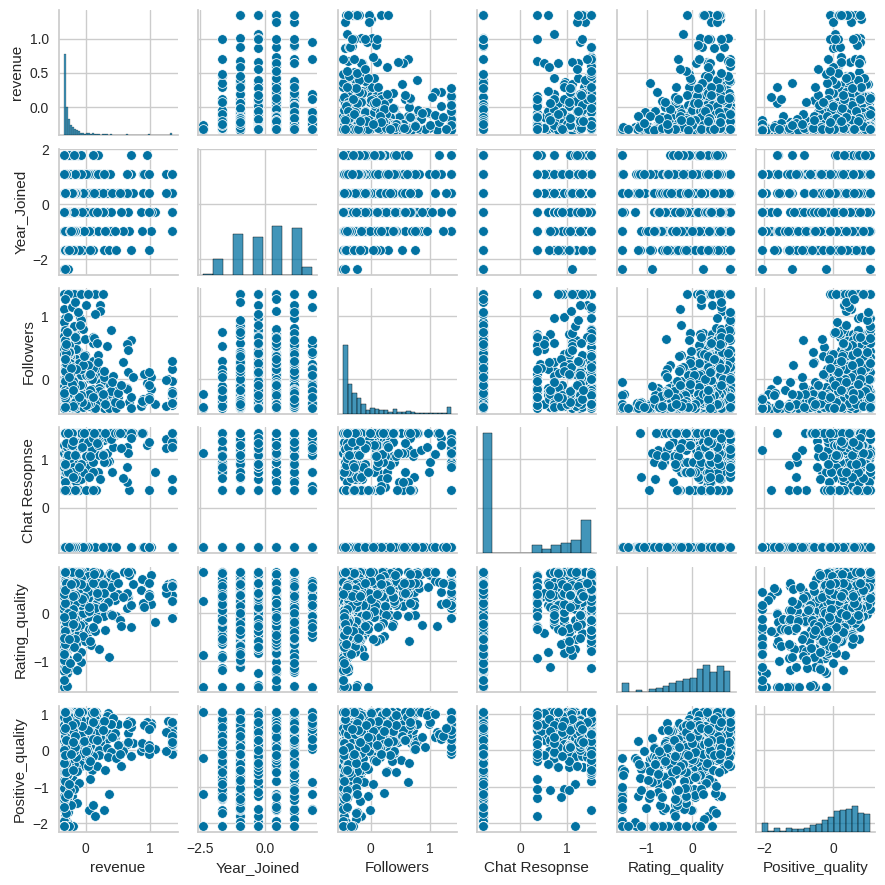

In [31]:
sns.pairplot(X_non_noise, height=1.5)
plt.show()

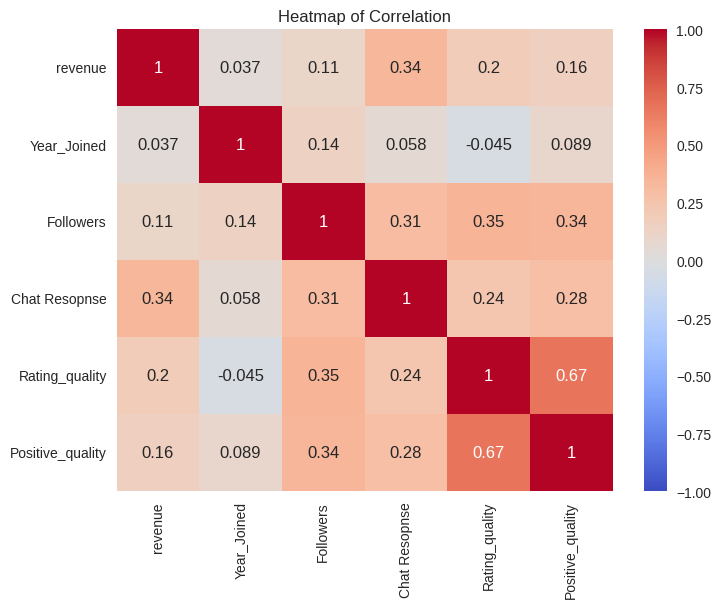

In [32]:
correlation_matrix = X_non_noise.corr()

# Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Heatmap of Correlation")
plt.show()

# ***`KMeans ++`***

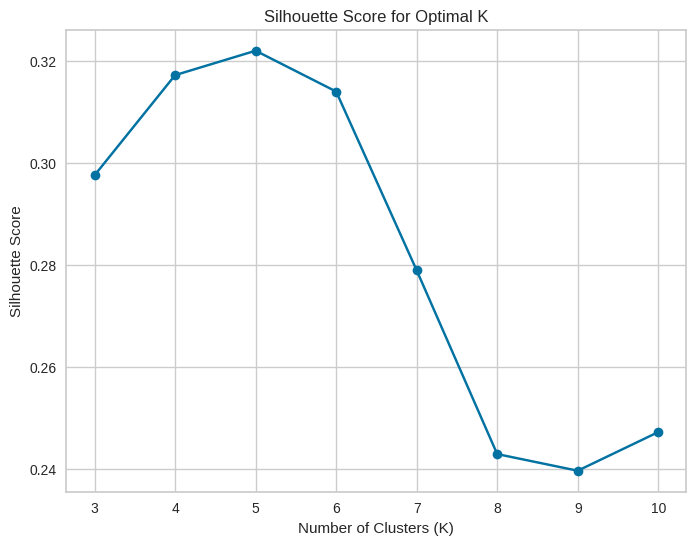

The optimal number of clusters is: 5


In [37]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

def find_optimal_clusters(data, max_clusters=12):
    """
    Tìm số cụm tối ưu bằng Silhouette Score.

    Parameters:
    - data: Dữ liệu đầu vào (mảng numpy hoặc pandas DataFrame).
    - max_clusters: Số cụm tối đa để kiểm tra (mặc định là 10).

    Returns:
    - optimal_k: Số cụm tối ưu.
    """
    silhouette_scores = []
    cluster_range = range(3, max_clusters + 1)  # Thử nghiệm từ 2 đến max_clusters

    for k in cluster_range:
        kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
        cluster_labels = kmeans.fit_predict(data)
        silhouette_avg = silhouette_score(data, cluster_labels)
        silhouette_scores.append(silhouette_avg)

    # Vẽ đồ thị Silhouette Score
    plt.figure(figsize=(8, 6))
    plt.plot(cluster_range, silhouette_scores, marker='o')
    plt.title('Silhouette Score for Optimal K')
    plt.xlabel('Number of Clusters (K)')
    plt.ylabel('Silhouette Score')
    plt.grid(True)
    plt.show()

    # Tìm số cụm tối ưu với Silhouette Score lớn nhất
    optimal_k = cluster_range[silhouette_scores.index(max(silhouette_scores))]
    print(f"The optimal number of clusters is: {optimal_k}")

    return optimal_k

# Ví dụ sử dụng:
# Giả sử `df_cleaned` là dữ liệu đã được tiền xử lý.
optimal_k = find_optimal_clusters(X_non_noise, max_clusters=10)


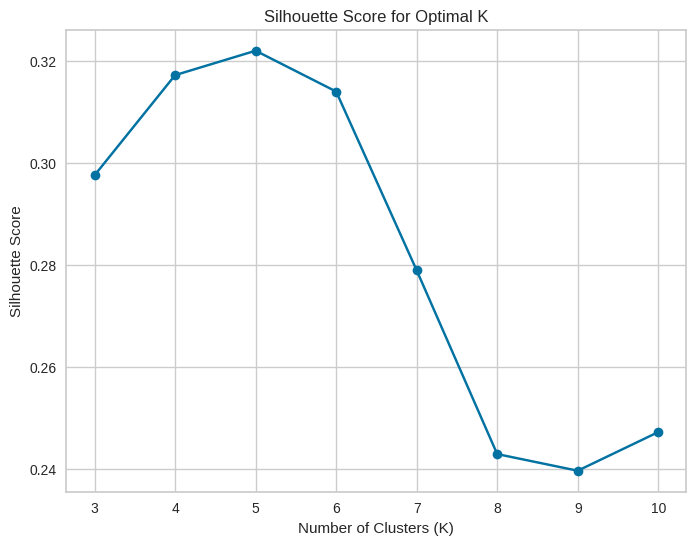

The optimal number of clusters is: 5
   Number of Clusters  Silhouette Score
0                   3          0.297528
1                   4          0.317150
2                   5          0.321934
3                   6          0.313937
4                   7          0.278896
5                   8          0.242886
6                   9          0.239623
7                  10          0.247194


In [38]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

def find_optimal_clusters_with_dataframe(data, max_clusters=10):
    """
    Tìm số cụm tối ưu và tạo bảng Silhouette Score từng cụm.

    Parameters:
    - data: Dữ liệu đầu vào (mảng numpy hoặc pandas DataFrame).
    - max_clusters: Số cụm tối đa để kiểm tra (mặc định là 10).

    Returns:
    - optimal_k: Số cụm tối ưu.
    - silhouette_df: DataFrame chứa Silhouette Score cho từng số cụm.
    """
    silhouette_scores = []
    cluster_range = range(3, max_clusters + 1)  # Thử nghiệm từ 2 đến max_clusters

    for k in cluster_range:
        kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
        cluster_labels = kmeans.fit_predict(data)
        silhouette_avg = silhouette_score(data, cluster_labels)
        silhouette_scores.append({'Number of Clusters': k, 'Silhouette Score': silhouette_avg})

    # Chuyển danh sách silhouette_scores thành DataFrame
    silhouette_df = pd.DataFrame(silhouette_scores)

    # Vẽ đồ thị Silhouette Score
    plt.figure(figsize=(8, 6))
    plt.plot(silhouette_df['Number of Clusters'], silhouette_df['Silhouette Score'], marker='o')
    plt.title('Silhouette Score for Optimal K')
    plt.xlabel('Number of Clusters (K)')
    plt.ylabel('Silhouette Score')
    plt.grid(True)
    plt.show()

    # Tìm số cụm tối ưu với Silhouette Score lớn nhất
    optimal_k = silhouette_df.loc[silhouette_df['Silhouette Score'].idxmax(), 'Number of Clusters']
    print(f"The optimal number of clusters is: {optimal_k}")

    return optimal_k, silhouette_df

# Ví dụ sử dụng:
# Giả sử `X_non_noise` là dữ liệu đã được tiền xử lý.
optimal_k, silhouette_df = find_optimal_clusters_with_dataframe(X_non_noise, max_clusters=10)

# In bảng kết quả
print(silhouette_df)


In [39]:
# Step 2: Apply K-Means++ with k=5
kmeans = KMeans(n_clusters=6, init="k-means++", random_state=42)
labels = kmeans.fit_predict(X_non_noise)

# Step 3: Compute silhouette score
silhouette_avg = silhouette_score(X_non_noise, labels)
print(f"Silhouette Score: {silhouette_avg}")

Silhouette Score: 0.3139366540083416


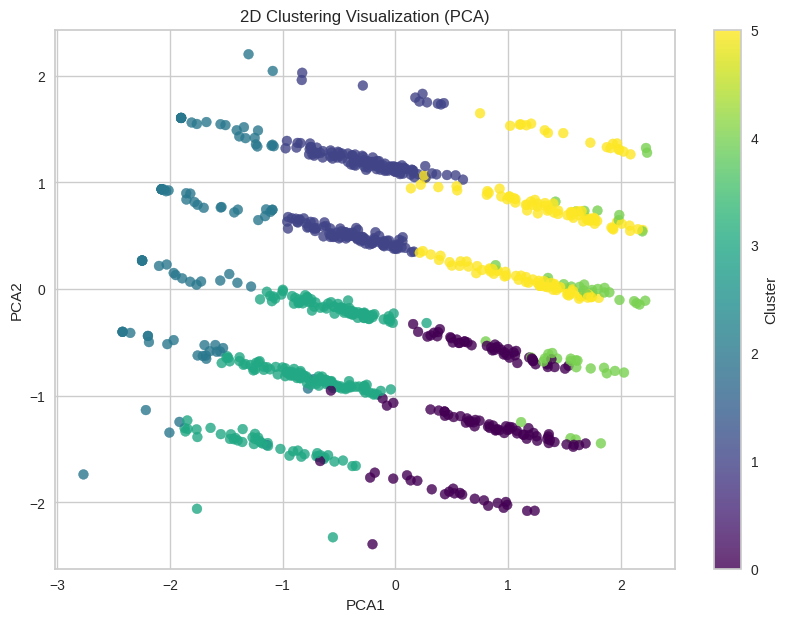

In [40]:
# Giảm chiều xuống 2D
pca_2d = PCA(n_components=2)
X_pca_2d = pca_2d.fit_transform(X_non_noise)

# Vẽ biểu đồ 2D
plt.figure(figsize=(10, 7))
scatter = plt.scatter(
    X_pca_2d[:, 0], X_pca_2d[:, 1],
    c=labels, cmap='viridis', s=50, alpha=0.8
)

# Tùy chỉnh biểu đồ
plt.title("2D Clustering Visualization (PCA)")
plt.xlabel("PCA1")
plt.ylabel("PCA2")
plt.colorbar(scatter, label='Cluster')
plt.show()

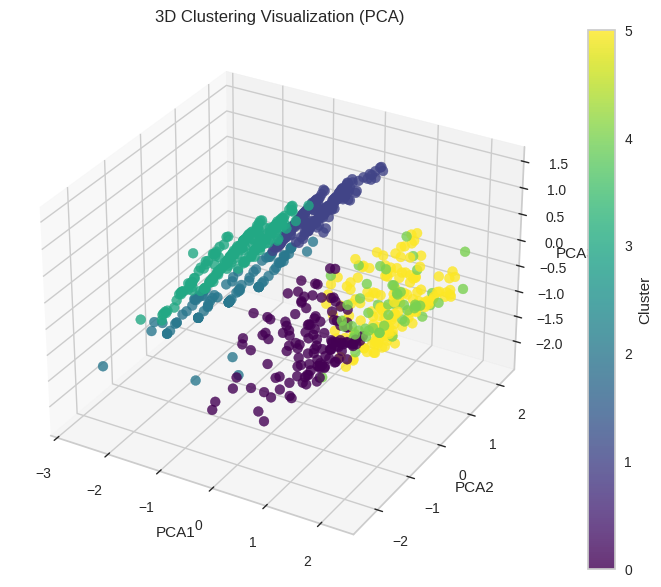

In [41]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Giảm chiều dữ liệu xuống 3D
pca_3d = PCA(n_components=3)
X_pca_3d = pca_3d.fit_transform(X_non_noise)

# Vẽ biểu đồ 3D
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Biểu đồ tán xạ 3D
scatter = ax.scatter(
    X_pca_3d[:, 0], X_pca_3d[:, 1], X_pca_3d[:, 2],
    c=labels, cmap='viridis', s=50, alpha=0.8
)

# Tùy chỉnh biểu đồ
ax.set_title("3D Clustering Visualization (PCA)")
ax.set_xlabel("PCA1")
ax.set_ylabel("PCA2")
ax.set_zlabel("PCA3")

# Thêm thanh màu để biểu diễn cụm
fig.colorbar(scatter, ax=ax, label='Cluster')

# Hiển thị biểu đồ
plt.show()


# ***`FREQUENT ITEMSET`***

# ***`K-Bin Discritizer`***

In [42]:
def apply_kmeans(column_data, n_clusters=3):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    column_data = column_data.values.reshape(-1, 1)  # Reshape for single feature
    return kmeans.fit_predict(column_data)

# Apply K-Means to each column
clustered_columns = {}
for column in X_non_noise.columns:
    clustered_columns[column] = apply_kmeans(X_non_noise[column])

# Add the cluster labels to the DataFrame
for column, labels in clustered_columns.items():
    X_non_noise[f'{column}_class'] = labels


In [43]:
X_non_noise.head(2)

,revenue,Year_Joined,Followers,Chat Resopnse,Rating_quality,Positive_quality,revenue_class,Year_Joined_class,Followers_class,Chat Resopnse_class,Rating_quality_class,Positive_quality_class
0,-0.326840,-0.279443,-0.143533,-0.819518,0.517466,0.731572,1,2,0,1,0,0
1,-0.143226,-0.972848,0.031235,-0.819518,0.539159,0.189270,1,0,2,1,0,2


In [44]:
min_max_df = X_non_noise.groupby('Positive_quality_class')['Positive_quality'].agg(['min', 'max'])
print(min_max_df)

                             min       max
Positive_quality_class                    
0                       0.235813  1.056228
1                      -2.078343 -0.912847
2                      -0.890794  0.232537


In [45]:
# Revenue
X_non_noise['revenue_class'] = X_non_noise['revenue_class'].replace(0, "Medium")
X_non_noise['revenue_class'] = X_non_noise['revenue_class'].replace(1, "Low")
X_non_noise['revenue_class'] = X_non_noise['revenue_class'].replace(2, "High")
#Year_Joined
X_non_noise['Year_Joined_class'] = X_non_noise['Year_Joined_class'].replace(0, "Low")
X_non_noise['Year_Joined_class'] = X_non_noise['Year_Joined_class'].replace(1, "High")
X_non_noise['Year_Joined_class'] = X_non_noise['Year_Joined_class'].replace(2, "Medium")
# Followers
X_non_noise['Followers_class'] = X_non_noise['Followers_class'].replace(0, "Low")
X_non_noise['Followers_class'] = X_non_noise['Followers_class'].replace(1, "High")
X_non_noise['Followers_class'] = X_non_noise['Followers_class'].replace(2, "Medim")
# Chat Resopnse
X_non_noise['Chat Resopnse_class'] = X_non_noise['Chat Resopnse_class'].replace(0, "Medium")
X_non_noise['Chat Resopnse_class'] = X_non_noise['Chat Resopnse_class'].replace(1, "Low")
X_non_noise['Chat Resopnse_class'] = X_non_noise['Chat Resopnse_class'].replace(2, "High")
#Rating Quality
X_non_noise['Rating_quality_class'] = X_non_noise['Rating_quality_class'].replace(0, "High")
X_non_noise['Rating_quality_class'] = X_non_noise['Rating_quality_class'].replace(1, "Medium")
X_non_noise['Rating_quality_class'] = X_non_noise['Rating_quality_class'].replace(2, "Low")
#positive
X_non_noise['Positive_quality_class'] = X_non_noise['Positive_quality_class'].replace(0, "High")
X_non_noise['Positive_quality_class'] = X_non_noise['Positive_quality_class'].replace(1, "Low")
X_non_noise['Positive_quality_class'] = X_non_noise['Positive_quality_class'].replace(2, "Medium")

In [46]:
# X_non_noise.to_excel('/content/drive/My Drive/Colab Notebooks/NCKH (Ph. Danh Hường)/Data thô/data_discretization.xlsx')

# ***`FP-Max`***

In [47]:
X_non_noise_cate = X_non_noise.iloc[:, 6:]
X_non_noise_dummies = pd.get_dummies(X_non_noise_cate)

In [48]:
item_count = {}
for col in X_non_noise_dummies.columns:
    item_count[col] = X_non_noise_dummies[col].sum()
item_freq_df = pd.DataFrame(data=list(item_count.values()), index=list(item_count.keys()), columns=['frequency']).sort_values(by='frequency', ascending=False)
item_freq_df.shape, item_freq_df

((18, 1),
                                frequency
 revenue_class_Low                    714
 Followers_class_Low                  640
 Chat Resopnse_class_Low              521
 Rating_quality_class_High            501
 Positive_quality_class_High          437
 Year_Joined_class_Medium             372
 Positive_quality_class_Medium        319
 Rating_quality_class_Medium          280
 Year_Joined_class_Low                250
 Year_Joined_class_High               233
 Chat Resopnse_class_High             224
 Followers_class_Medim                151
 Chat Resopnse_class_Medium           110
 revenue_class_Medium                 102
 Positive_quality_class_Low            99
 Rating_quality_class_Low              74
 Followers_class_High                  64
 revenue_class_High                    39)

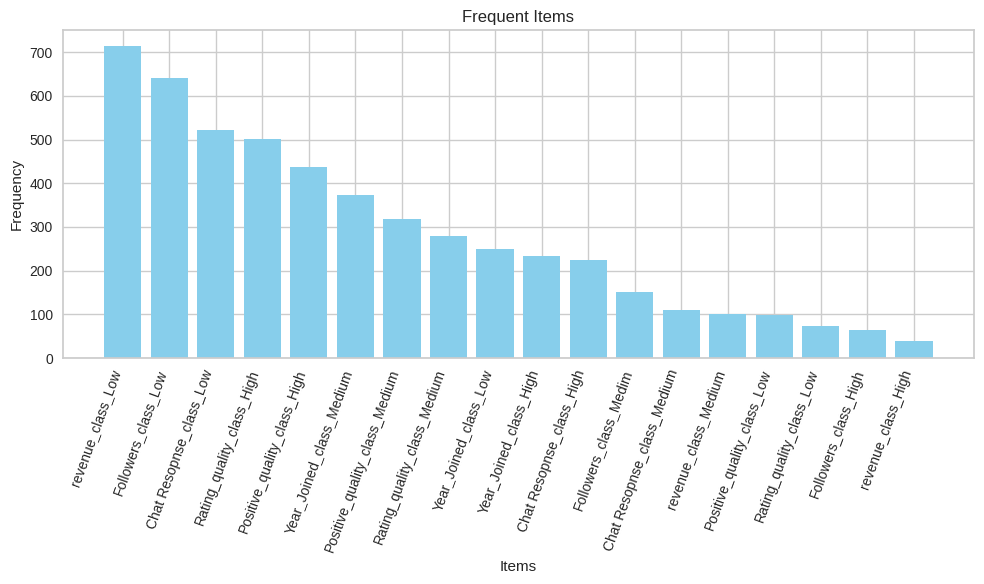

In [49]:
# Calculate the sum of each column (representing the frequency of each item)
column_sums = X_non_noise_dummies.sum()
# Sort the columns by sum in descending order
sorted_columns = column_sums.sort_values(ascending=False)

# Create a bar chart
plt.figure(figsize=(10, 6))
plt.bar(sorted_columns.index, sorted_columns.values, color='skyblue')
plt.xlabel('Items')
plt.ylabel('Frequency')
plt.title('Frequent Items')
plt.xticks(rotation=70, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

In [50]:
from mlxtend.frequent_patterns import fpmax

# Tìm các tập mục phổ biến tối đại
frequent_itemsets = fpmax(X_non_noise_dummies, min_support=0.2, use_colnames=True)
frequent_itemsets = pd.DataFrame(frequent_itemsets)

In [51]:
frequent_itemsets = frequent_itemsets.sort_values(by='support', ascending=False)
frequent_itemsets = pd.DataFrame(frequent_itemsets)
print(frequent_itemsets)

     support                                           itemsets
0   0.261988                         (Chat Resopnse_class_High)
5   0.256140  (Rating_quality_class_Medium, revenue_class_Lo...
11  0.243275  (Positive_quality_class_High, Chat Resopnse_cl...
1   0.230409        (revenue_class_Low, Year_Joined_class_High)
7   0.230409  (Positive_quality_class_High, Year_Joined_clas...
13  0.223392  (Rating_quality_class_High, Chat Resopnse_clas...
2   0.211696  (Followers_class_Low, revenue_class_Low, Year_...
12  0.207018  (Rating_quality_class_High, Positive_quality_c...
8   0.204678  (Chat Resopnse_class_Low, revenue_class_Low, Y...
4   0.203509  (Chat Resopnse_class_Low, Rating_quality_class...
6   0.203509  (Positive_quality_class_Medium, Chat Resopnse_...
10  0.203509  (Positive_quality_class_High, Chat Resopnse_cl...
3   0.202339  (Rating_quality_class_Medium, Chat Resopnse_cl...
9   0.202339  (Rating_quality_class_High, revenue_class_Low,...


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [52]:
frequent_itemsets.to_excel('/content/drive/My Drive/Colab Notebooks/NCKH (Ph. Danh Hường)/Data thô/data_fpmax.xlsx')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# ***`New Features`***

In [53]:
X_non_noise.head(2)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,revenue,Year_Joined,Followers,Chat Resopnse,Rating_quality,Positive_quality,revenue_class,Year_Joined_class,Followers_class,Chat Resopnse_class,Rating_quality_class,Positive_quality_class
0,-0.326840,-0.279443,-0.143533,-0.819518,0.517466,0.731572,Low,Medium,Low,Low,High,High
1,-0.143226,-0.972848,0.031235,-0.819518,0.539159,0.189270,Low,Low,Medim,Low,High,Medium


In [54]:
# 1. 'Chat Resopnse_class_High'
X_non_noise['Chat_Resopnse_High'] = (X_non_noise['Chat Resopnse_class'] == 'High').astype(int)

# 2. 'revenue_class_Low', 'Rating_quality_class_Medium', 'Followers_class_Low'
X_non_noise['revenue_Low_Rating_Medium_Followers_Low'] = (
    (X_non_noise['revenue_class'] == 'Low') &
    (X_non_noise['Rating_quality_class'] == 'Medium') &
    (X_non_noise['Followers_class'] == 'Low')
).astype(int)

# 3. 'revenue_class_Low', 'Positive_quality_class_High', 'Chat Resopnse_class_Low'
X_non_noise['revenue_Low_Positive_High_Chat_Low'] = (
    (X_non_noise['revenue_class'] == 'Low') &
    (X_non_noise['Positive_quality_class'] == 'High') &
    (X_non_noise['Chat Resopnse_class'] == 'Low')
).astype(int)

# 4. 'revenue_class_Low', 'Year_Joined_class_High'
X_non_noise['revenue_Low_Year_Joined_High'] = (
    (X_non_noise['revenue_class'] == 'Low') &
    (X_non_noise['Year_Joined_class'] == 'High')
).astype(int)

# 5. 'Positive_quality_class_High', 'Year_Joined_class_Medium'
X_non_noise['Positive_High_Year_Medium'] = (
    (X_non_noise['Positive_quality_class'] == 'High') &
    (X_non_noise['Year_Joined_class'] == 'Medium')
).astype(int)

# 6. 'revenue_class_Low', 'Chat Resopnse_class_Low', 'Rating_quality_class_High', 'Followers_class_Low'
X_non_noise['revenue_Low_Chat_Low_Rating_High_Followers_Low'] = (
    (X_non_noise['revenue_class'] == 'Low') &
    (X_non_noise['Chat Resopnse_class'] == 'Low') &
    (X_non_noise['Rating_quality_class'] == 'High') &
    (X_non_noise['Followers_class'] == 'Low')
).astype(int)

# 7. 'revenue_class_Low', 'Year_Joined_class_Low', 'Followers_class_Low'
X_non_noise['revenue_Low_Year_Low_Followers_Low'] = (
    (X_non_noise['revenue_class'] == 'Low') &
    (X_non_noise['Year_Joined_class'] == 'Low') &
    (X_non_noise['Followers_class'] == 'Low')
).astype(int)

# 8. 'revenue_class_Low', 'Positive_quality_class_High', 'Rating_quality_class_High', 'Followers_class_Low'
X_non_noise['revenue_Low_Positive_High_Rating_High_Followers_Low'] = (
    (X_non_noise['revenue_class'] == 'Low') &
    (X_non_noise['Positive_quality_class'] == 'High') &
    (X_non_noise['Rating_quality_class'] == 'High') &
    (X_non_noise['Followers_class'] == 'Low')
).astype(int)

# 9. 'revenue_class_Low', 'Chat Resopnse_class_Low', 'Year_Joined_class_Medium', 'Followers_class_Low'
X_non_noise['revenue_Low_Chat_Low_Year_Medium_Followers_Low'] = (
    (X_non_noise['revenue_class'] == 'Low') &
    (X_non_noise['Chat Resopnse_class'] == 'Low') &
    (X_non_noise['Year_Joined_class'] == 'Medium') &
    (X_non_noise['Followers_class'] == 'Low')
).astype(int)

# 10. 'Followers_class_Low', 'Rating_quality_class_Medium', 'Chat Resopnse_class_Low'
X_non_noise['Followers_Low_Rating_Medium_Chat_Low'] = (
    (X_non_noise['Followers_class'] == 'Low') &
    (X_non_noise['Rating_quality_class'] == 'Medium') &
    (X_non_noise['Chat Resopnse_class'] == 'Low')
).astype(int)

# 11. 'revenue_class_Low', 'Chat Resopnse_class_Low', 'Positive_quality_class_Medium', 'Followers_class_Low'
X_non_noise['revenue_Low_Chat_Low_Positive_Medium_Followers_Low'] = (
    (X_non_noise['revenue_class'] == 'Low') &
    (X_non_noise['Chat Resopnse_class'] == 'Low') &
    (X_non_noise['Positive_quality_class'] == 'Medium') &
    (X_non_noise['Followers_class'] == 'Low')
).astype(int)

# 12. 'Followers_class_Low', 'Positive_quality_class_High', 'Chat Resopnse_class_Low'
X_non_noise['Followers_Low_Positive_High_Chat_Low'] = (
    (X_non_noise['Followers_class'] == 'Low') &
    (X_non_noise['Positive_quality_class'] == 'High') &
    (X_non_noise['Chat Resopnse_class'] == 'Low')
).astype(int)

# 13. 'revenue_class_Low', 'Rating_quality_class_Medium', 'Chat Resopnse_class_Low'
X_non_noise['revenue_Low_Rating_Medium_Chat_Low'] = (
    (X_non_noise['revenue_class'] == 'Low') &
    (X_non_noise['Rating_quality_class'] == 'Medium') &
    (X_non_noise['Chat Resopnse_class'] == 'Low')
).astype(int)

# 14. 'revenue_class_Low', 'Year_Joined_class_Medium', 'Rating_quality_class_High'
X_non_noise['revenue_Low_Year_Medium_Rating_High'] = (
    (X_non_noise['revenue_class'] == 'Low') &
    (X_non_noise['Year_Joined_class'] == 'Medium') &
    (X_non_noise['Rating_quality_class'] == 'High')
).astype(int)




/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [55]:
X_non_noise.head(2)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,revenue,Year_Joined,Followers,Chat Resopnse,Rating_quality,Positive_quality,revenue_class,Year_Joined_class,Followers_class,Chat Resopnse_class,...,Positive_High_Year_Medium,revenue_Low_Chat_Low_Rating_High_Followers_Low,revenue_Low_Year_Low_Followers_Low,revenue_Low_Positive_High_Rating_High_Followers_Low,revenue_Low_Chat_Low_Year_Medium_Followers_Low,Followers_Low_Rating_Medium_Chat_Low,revenue_Low_Chat_Low_Positive_Medium_Followers_Low,Followers_Low_Positive_High_Chat_Low,revenue_Low_Rating_Medium_Chat_Low,revenue_Low_Year_Medium_Rating_High
0,-0.326840,-0.279443,-0.143533,-0.819518,0.517466,0.731572,Low,Medium,Low,Low,...,1,1,0,1,1,0,0,1,0,1
1,-0.143226,-0.972848,0.031235,-0.819518,0.539159,0.189270,Low,Low,Medim,Low,...,0,0,0,0,0,0,0,0,0,0


In [56]:
X_non_noise_final = X_non_noise.drop(columns = ['revenue_class', 'Year_Joined_class', 'Followers_class', 'Chat Resopnse_class', 'Rating_quality_class', 'Positive_quality_class'])
X_non_noise_final.head(2)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,revenue,Year_Joined,Followers,Chat Resopnse,Rating_quality,Positive_quality,Chat_Resopnse_High,revenue_Low_Rating_Medium_Followers_Low,revenue_Low_Positive_High_Chat_Low,revenue_Low_Year_Joined_High,Positive_High_Year_Medium,revenue_Low_Chat_Low_Rating_High_Followers_Low,revenue_Low_Year_Low_Followers_Low,revenue_Low_Positive_High_Rating_High_Followers_Low,revenue_Low_Chat_Low_Year_Medium_Followers_Low,Followers_Low_Rating_Medium_Chat_Low,revenue_Low_Chat_Low_Positive_Medium_Followers_Low,Followers_Low_Positive_High_Chat_Low,revenue_Low_Rating_Medium_Chat_Low,revenue_Low_Year_Medium_Rating_High
0,-0.326840,-0.279443,-0.143533,-0.819518,0.517466,0.731572,0,0,1,0,1,1,0,1,1,0,0,1,0,1
1,-0.143226,-0.972848,0.031235,-0.819518,0.539159,0.189270,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [57]:
X_non_noise_final.to_excel('/content/drive/My Drive/Colab Notebooks/NCKH (Ph. Danh Hường)/Data thô/data_final.xlsx')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# ***`Forward Selection`***

In [58]:
X_non_noise_final_continuous = X_non_noise_final.iloc[:, :6]
X_non_noise_final_categorical = X_non_noise_final.iloc[:, 6:]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [59]:
import numpy as np
from kmodes.kprototypes import KPrototypes
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import pdist, squareform

# Hàm tính khoảng cách Gower cho dữ liệu hỗn hợp
def gower_distance(data):
    D = np.zeros((data.shape[0], data.shape[0]))
    for i in range(data.shape[1]):
        if i < len(selected_features.columns):  # Continuous variables
            D += squareform(pdist(data[:, [i]], metric='euclidean')) / (data[:, [i]].max() - data[:, [i]].min())
        else:  # Binary or categorical variables
            D += squareform(pdist(data[:, [i]], metric='hamming'))
    return D / data.shape[1]

# Initialize
selected_features = X_non_noise_final_continuous.copy()  # Bắt đầu với các biến liên tục
best_silhouette_score = -1  # Khởi tạo với giá trị silhouette thấp nhất có thể
binary_features = X_non_noise_final_categorical.copy()  # Danh sách các biến nhị phân mới

while len(binary_features.columns) > 0:
    best_feature = None
    for binary_feature_name in binary_features.columns:
        # Thêm biến nhị phân hiện tại vào bộ dữ liệu
        current_features = selected_features.copy()
        current_features[binary_feature_name] = binary_features[binary_feature_name]

        # Thực hiện phân cụm K-Prototypes
        kproto = KPrototypes(n_clusters=5, random_state=42)  # Số cụm = 6
        categorical_columns = list(range(len(selected_features.columns), len(current_features.columns)))  # Định nghĩa các cột nhị phân
        labels = kproto.fit_predict(current_features, categorical=categorical_columns)

        # Tính khoảng cách Gower cho dữ liệu hỗn hợp
        gower_dist = gower_distance(current_features.values)

        # Tính Silhouette Score cho khoảng cách hỗn hợp
        current_silhouette_score = silhouette_score(gower_dist, labels, metric="precomputed")

        # Kiểm tra nếu Silhouette Score tăng, giữ lại biến nhị phân tốt nhất
        if current_silhouette_score > best_silhouette_score:
            best_silhouette_score = current_silhouette_score
            best_feature = binary_feature_name

    # Nếu không có biến nhị phân nào cải thiện Silhouette Score, dừng quá trình
    if best_feature is None:
        break

    # Thêm biến nhị phân tốt nhất vào bộ feature đã chọn
    selected_features[best_feature] = binary_features[best_feature]

    # Loại bỏ biến nhị phân đã được chọn khỏi danh sách các feature còn lại
    binary_features = binary_features.drop(columns=[best_feature])

# In ra các feature đã được chọn và Silhouette Score tốt nhất
print("Selected features: ", selected_features.columns)
print("Best Silhouette Score: ", best_silhouette_score)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


KeyboardInterrupt: 

# ***`Final Clustering`***

In [60]:
from kmodes.kprototypes import KPrototypes
from sklearn.metrics import silhouette_score, davies_bouldin_score
from gower import gower_matrix

# Danh sách các cột đặc trưng
feature_names = ['revenue', 'Year_Joined', 'Followers', 'Chat Resopnse',
                 'Rating_quality', 'Positive_quality',
                 'revenue_Low_Year_Low_Followers_Low',
                 'revenue_Low_Chat_Low_Positive_Medium_Followers_Low',
                 'revenue_Low_Positive_High_Chat_Low']

# Chọn dữ liệu không nhiễu với các đặc trưng cần thiết
X_non_noise_final_1 = X_non_noise_final[feature_names]

# Chỉ định các cột phân loại (categorical), cần đánh số 0-based
categorical_columns_indices = [6, 7, 8]  # Các cột này là dữ liệu phân loại

# Áp dụng K-Prototypes
kproto = KPrototypes(n_clusters=6, init='Cao', random_state=42)
clusters = kproto.fit_predict(X_non_noise_final_1, categorical=categorical_columns_indices)

# Thêm nhãn cụm vào DataFrame gốc
X_non_noise_final_1['Cluster'] = clusters

# Tính khoảng cách Gower cho dữ liệu hỗn hợp
gower_distances = gower_matrix(X_non_noise_final_1)

# Tính Silhouette Score với khoảng cách Gower
silhouette_avg = silhouette_score(gower_distances, X_non_noise_final_1['Cluster'], metric="precomputed")

# Tính Davies-Bouldin Index với khoảng cách Gower
davies_bouldin_avg = davies_bouldin_score(gower_distances, X_non_noise_final_1['Cluster'])

# In kết quả đánh giá
print("Silhouette Score (dữ liệu hỗn hợp):", silhouette_avg)
print("Davies-Bouldin Index (dữ liệu hỗn hợp):", davies_bouldin_avg)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Silhouette Score (dữ liệu hỗn hợp): 0.35484323
Davies-Bouldin Index (dữ liệu hỗn hợp): 1.5126760311451888


In [61]:
# Sau khi mô hình được huấn luyện
print(f'Cost (Chi phí của mô hình): {kproto.cost_}')

Cost (Chi phí của mô hình): 963.5459160836871


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# ***`Visualize`***

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


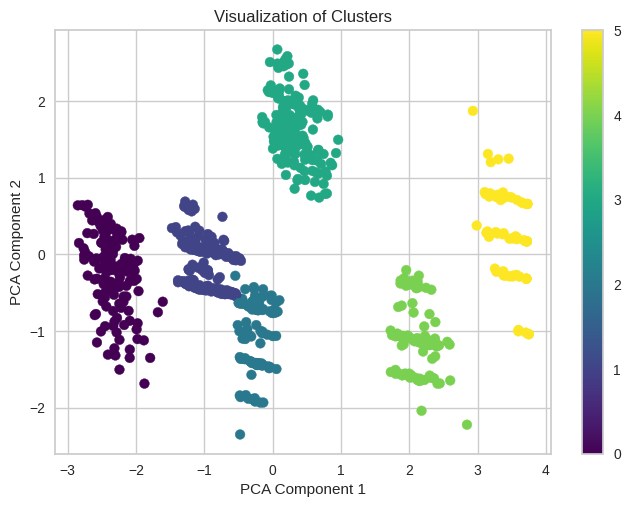

In [62]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Giảm dữ liệu xuống 2 chiều bằng PCA
pca = PCA(2)
reduced_data = pca.fit_transform(X_non_noise_final_1)

# Vẽ biểu đồ
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=clusters, cmap='viridis')
plt.title('Visualization of Clusters')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar()
plt.show()


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


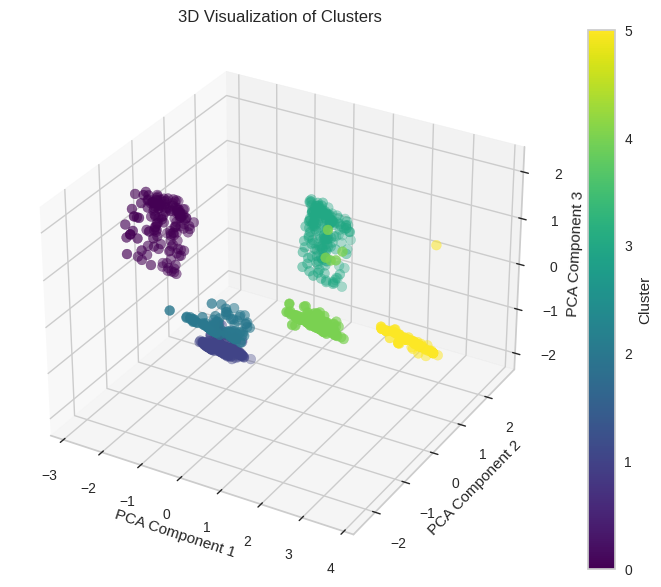

In [63]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

# Giảm dữ liệu xuống 3 chiều bằng PCA
pca = PCA(3)
reduced_data = pca.fit_transform(X_non_noise_final_1)

# Vẽ biểu đồ 3D
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(reduced_data[:, 0], reduced_data[:, 1], reduced_data[:, 2],
                     c=clusters, cmap='viridis', s=50)

# Thiết lập nhãn và tiêu đề
ax.set_title('3D Visualization of Clusters')
ax.set_xlabel('PCA Component 1')
ax.set_ylabel('PCA Component 2')
ax.set_zlabel('PCA Component 3')
fig.colorbar(scatter, ax=ax, label='Cluster')

plt.show()


# ***`GMM`***

In [64]:
X = X_non_noise_final[feature_names]  # Dữ liệu đã chuẩn hóa
X

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,revenue,Year_Joined,Followers,Chat Resopnse,Rating_quality,Positive_quality,revenue_Low_Year_Low_Followers_Low,revenue_Low_Chat_Low_Positive_Medium_Followers_Low,revenue_Low_Positive_High_Chat_Low
0,-0.326840,-0.279443,-0.143533,-0.819518,0.517466,0.731572,0,0,1
1,-0.143226,-0.972848,0.031235,-0.819518,0.539159,0.189270,0,0,0
2,-0.260906,0.413962,1.358861,1.525984,0.663007,1.056228,0,0,0
3,-0.313024,1.107368,-0.313240,-0.819518,-0.090066,0.500853,0,0,1
4,-0.287069,0.413962,-0.284224,1.525984,0.379822,0.768611,0,0,0
...,...,...,...,...,...,...,...,...,...
927,-0.321503,-2.359659,-0.442460,-0.819518,0.837530,1.056228,1,0,1
928,0.292289,-0.972848,-0.408721,1.525984,-0.349262,-0.545265,0,0,0
929,0.176205,-0.279443,0.581516,1.314889,0.410154,0.269981,0,0,0
930,-0.203387,-1.666254,-0.183682,1.361799,0.353820,0.214836,1,0,0


In [73]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.mixture import GaussianMixture
import numpy as np

# X_non_noise_final là dữ liệu của bạn, feature_names là tên các đặc trưng
# Giả sử bạn có dữ liệu gồm biến liên tục và nhị phân và dữ liệu đã được chuẩn hóa

X = X_non_noise_final[feature_names]  # Dữ liệu đã chuẩn hóa

# Xác định các chỉ số của các cột liên tục và nhị phân
# Ví dụ giả sử các cột số (liên tục) có chỉ số 0, 1 và các cột nhị phân có chỉ số 2, 3
# Điều chỉnh cho phù hợp với dữ liệu của bạn

# Hàm kiểm tra liệu biến là liên tục hay nhị phân
def is_continuous(feature_name):
    continuous_features = ['revenue',	'Year_Joined',	'Followers',	'Chat Resopnse',	'Rating_quality',	'Positive_quality']  # Ví dụ các đặc trưng liên tục
    return feature_name in continuous_features

def is_binary(feature_name):
    binary_features = ['revenue_Low_Year_Low_Followers_Low',	'revenue_Low_Chat_Low_Positive_Medium_Followers_Low',	'revenue_Low_Positive_High_Chat_Low']  # Ví dụ các đặc trưng nhị phân
    return feature_name in binary_features

# Định nghĩa mạng nơ-ron để học các đặc trưng tiềm ẩn
class DeepEmbeddingNN(nn.Module):
    def __init__(self, input_dim, latent_dim=2):
        super(DeepEmbeddingNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, latent_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

def train_embedding_model(X):
    model = DeepEmbeddingNN(X.shape[1], latent_dim=2)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.MSELoss()

    # Chuyển dữ liệu thành tensor PyTorch
    # Convert the DataFrame to a NumPy array before creating the tensor
    X_tensor = torch.tensor(X.values, dtype=torch.float32)

    # Vòng lặp huấn luyện
    for epoch in range(100):
        optimizer.zero_grad()
        embedded = model(X_tensor)
        loss = criterion(embedded, embedded)  # Mất mát tái tạo tự thân
        loss.backward()
        optimizer.step()

        if epoch % 10 == 0:
            print(f"Epoch [{epoch+1}/100], Loss: {loss.item():.4f}")

    return model

# Hàm thực hiện huấn luyện và phân cụm
def fit_md_gmm(X):
    # Dữ liệu đã được chuẩn hóa, không cần xử lý thêm

    # Huấn luyện mô hình embedding
    embedding_model = train_embedding_model(X)

    # Lấy các đặc trưng tiềm ẩn
    # Convert the DataFrame to a NumPy array before creating the tensor
    X_embedded = embedding_model(torch.tensor(X.values, dtype=torch.float32)).detach().numpy()

    # Phân cụm bằng Gaussian Mixture Model
    gmm = GaussianMixture(n_components=6, covariance_type='full')
    gmm.fit(X_embedded)
    labels = gmm.predict(X_embedded)

    return labels

# Áp dụng mô hình cho dữ liệu của bạn
labels = fit_md_gmm(X)

# In ra các nhãn phân cụm
print(labels)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Epoch [1/100], Loss: 0.0000
Epoch [11/100], Loss: 0.0000
Epoch [21/100], Loss: 0.0000
Epoch [31/100], Loss: 0.0000
Epoch [41/100], Loss: 0.0000
Epoch [51/100], Loss: 0.0000
Epoch [61/100], Loss: 0.0000
Epoch [71/100], Loss: 0.0000
Epoch [81/100], Loss: 0.0000
Epoch [91/100], Loss: 0.0000
[2 4 4 1 2 0 1 0 0 2 1 2 1 1 5 5 1 2 5 2 1 1 3 1 2 2 1 4 0 1 1 1 2 5 0 0 1
 2 4 0 1 1 2 1 1 2 0 1 1 1 1 2 1 1 1 1 2 5 3 0 1 1 1 1 3 4 2 1 0 0 0 1 0 1
 2 2 0 1 3 1 1 4 1 1 0 1 1 1 2 5 1 4 2 4 2 0 0 3 1 1 1 1 2 1 2 3 3 1 2 0 0
 1 0 1 0 0 1 4 2 1 3 3 1 5 1 0 2 3 0 5 2 0 3 1 1 0 5 1 2 2 4 0 3 1 3 4 1 0
 0 1 0 5 2 0 0 4 1 3 5 4 2 1 1 2 3 0 4 0 1 0 3 2 1 1 1 1 0 5 0 0 0 3 5 1 1
 0 1 1 4 1 3 4 0 3 5 1 5 1 2 2 1 2 0 1 3 5 2 0 1 1 2 2 1 5 5 1 3 1 1 5 1 3
 2 2 1 2 3 3 1 1 1 0 4 1 4 0 0 3 2 1 2 4 1 2 0 0 2 1 1 2 0 0 2 5 4 4 5 0 1
 1 1 2 0 0 0 1 3 1 1 1 0 1 2 2 1 3 5 4 1 0 3 2 4 1 4 2 2 0 1 2 2 2 2 0 2 3
 3 2 5 2 2 1 0 1 4 1 3 2 3 3 3 1 4 2 1 1 2 4 1 1 4 2 0 4 0 1 1 5 0 1 0 0 1
 4 0 2 3 1 2 2 4 1 2 1 4 1 0 2 4 5 2

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Epoch [1/100], Loss: 0.0000
Epoch [11/100], Loss: 0.0000
Epoch [21/100], Loss: 0.0000
Epoch [31/100], Loss: 0.0000
Epoch [41/100], Loss: 0.0000
Epoch [51/100], Loss: 0.0000
Epoch [61/100], Loss: 0.0000
Epoch [71/100], Loss: 0.0000
Epoch [81/100], Loss: 0.0000
Epoch [91/100], Loss: 0.0000
Silhouette Score: 0.3343


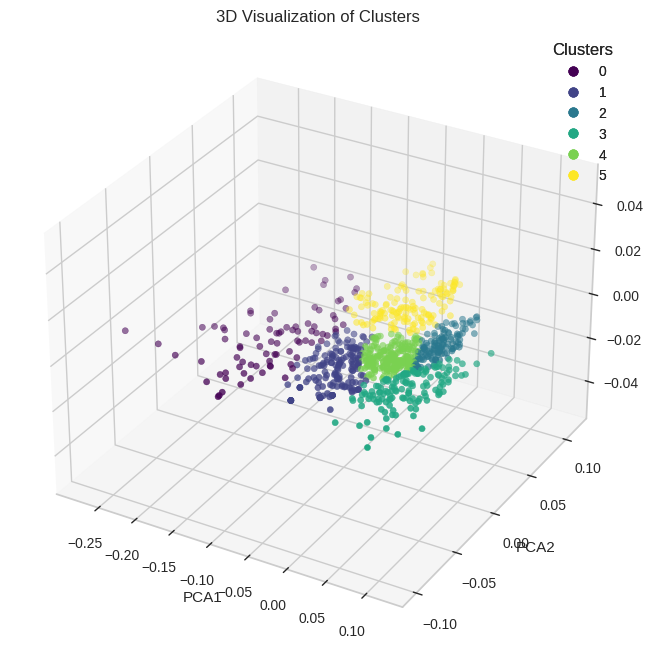

In [76]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA

# Định nghĩa mạng nơ-ron để học các đặc trưng tiềm ẩn
class DeepEmbeddingNN(nn.Module):
    def __init__(self, input_dim, latent_dim=2):
        super(DeepEmbeddingNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, latent_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

def train_embedding_model(X):
    model = DeepEmbeddingNN(X.shape[1], latent_dim=2)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.MSELoss()

    X_tensor = torch.tensor(X.values, dtype=torch.float32)

    for epoch in range(100):
        optimizer.zero_grad()
        embedded = model(X_tensor)
        loss = criterion(embedded, embedded)  # Mất mát tái tạo tự thân
        loss.backward()
        optimizer.step()

        if epoch % 10 == 0:
            print(f"Epoch [{epoch+1}/100], Loss: {loss.item():.4f}")

    return model

# Hàm thực hiện huấn luyện và phân cụm
def fit_md_gmm(X):
    embedding_model = train_embedding_model(X)

    X_embedded = embedding_model(torch.tensor(X.values, dtype=torch.float32)).detach().numpy()

    gmm = GaussianMixture(n_components=6, covariance_type='full')
    gmm.fit(X_embedded)
    labels = gmm.predict(X_embedded)

    return labels, X_embedded

# Áp dụng mô hình cho dữ liệu của bạn
labels, X_embedded = fit_md_gmm(X)

# Tính Silhouette Score
sil_score = silhouette_score(X_embedded, labels)
print(f"Silhouette Score: {sil_score:.4f}")

# Trực quan hóa dữ liệu trong không gian 3D
pca = PCA(n_components=2) # Change n_components to 2
X_embedded_3d = pca.fit_transform(X_embedded)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Vẽ điểm dữ liệu theo nhãn phân cụm
scatter = ax.scatter(X_embedded_3d[:, 0], X_embedded_3d[:, 1],  c=labels, cmap='viridis') #Remove the third dimension in scatter plot

# Tạo legend và title
legend1 = ax.legend(*scatter.legend_elements(), title="Clusters")
ax.add_artist(legend1)
ax.set_title("3D Visualization of Clusters")
ax.set_xlabel('PCA1')
ax.set_ylabel('PCA2')


plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Epoch [1/100], Loss: 0.0000
Epoch [11/100], Loss: 0.0000
Epoch [21/100], Loss: 0.0000
Epoch [31/100], Loss: 0.0000
Epoch [41/100], Loss: 0.0000
Epoch [51/100], Loss: 0.0000
Epoch [61/100], Loss: 0.0000
Epoch [71/100], Loss: 0.0000
Epoch [81/100], Loss: 0.0000
Epoch [91/100], Loss: 0.0000
Silhouette Score: 0.2096


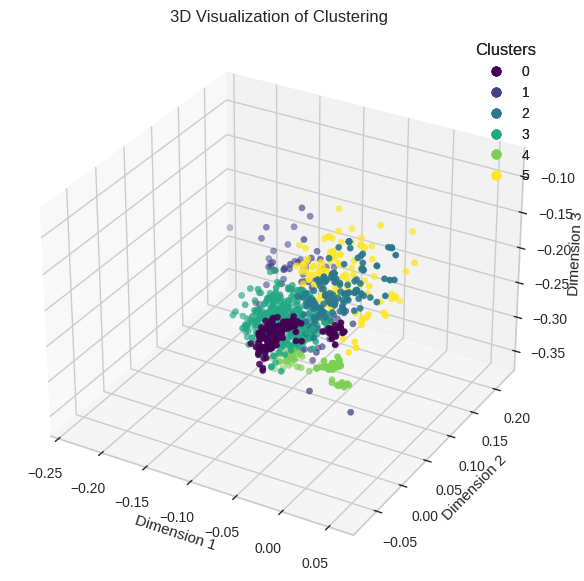

In [71]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# X_non_noise_final là dữ liệu của bạn, feature_names là tên các đặc trưng
# Giả sử bạn có dữ liệu gồm biến liên tục và nhị phân và dữ liệu đã được chuẩn hóa

X = X_non_noise_final[feature_names]  # Dữ liệu đã chuẩn hóa

# Định nghĩa mạng nơ-ron để học các đặc trưng tiềm ẩn
class DeepEmbeddingNN(nn.Module):
    def __init__(self, input_dim, latent_dim=3):  # Đặt latent_dim = 3 để sử dụng cho 3D visualization
        super(DeepEmbeddingNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, latent_dim)  # Đầu ra 3D

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

def train_embedding_model(X):
    model = DeepEmbeddingNN(X.shape[1], latent_dim=3)  # Kích thước đặc trưng tiềm ẩn là 3D
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.MSELoss()

    # Chuyển dữ liệu thành tensor PyTorch
    X_tensor = torch.tensor(X.values, dtype=torch.float32)

    # Vòng lặp huấn luyện
    for epoch in range(100):
        optimizer.zero_grad()
        embedded = model(X_tensor)
        loss = criterion(embedded, embedded)  # Mất mát tái tạo tự thân
        loss.backward()
        optimizer.step()

        if epoch % 10 == 0:
            print(f"Epoch [{epoch+1}/100], Loss: {loss.item():.4f}")

    return model

# Hàm thực hiện huấn luyện và phân cụm
def fit_md_gmm(X):
    # Dữ liệu đã được chuẩn hóa, không cần xử lý thêm

    # Huấn luyện mô hình embedding
    embedding_model = train_embedding_model(X)

    # Lấy các đặc trưng tiềm ẩn
    X_embedded = embedding_model(torch.tensor(X.values, dtype=torch.float32)).detach().numpy()

    # Phân cụm bằng Gaussian Mixture Model
    gmm = GaussianMixture(n_components=6, covariance_type='full')
    gmm.fit(X_embedded)
    labels = gmm.predict(X_embedded)

    return labels, X_embedded

# Áp dụng mô hình cho dữ liệu của bạn
labels, X_embedded = fit_md_gmm(X)

# Tính Silhouette Score
sil_score = silhouette_score(X_embedded, labels)
print(f"Silhouette Score: {sil_score:.4f}")

# Trực quan hóa trong không gian 3D
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Lấy các toạ độ của các đặc trưng tiềm ẩn (embeddings)
x = X_embedded[:, 0]
y = X_embedded[:, 1]
z = X_embedded[:, 2]

# Vẽ các điểm phân cụm với màu sắc khác nhau
scatter = ax.scatter(x, y, z, c=labels, cmap='viridis', marker='o')
ax.set_xlabel('Dimension 1')
ax.set_ylabel('Dimension 2')
ax.set_zlabel('Dimension 3')

# Thêm legend và tiêu đề
legend1 = ax.legend(*scatter.legend_elements(), title="Clusters")
ax.add_artist(legend1)
ax.set_title('3D Visualization of Clustering')

plt.show()


In [ ]:
X_non_noise.head(2)

In [ ]:
# Import the GaussianMixture class
from sklearn.mixture import GaussianMixture

# Set up a range of cluster numbers to try
n_range = range(3,11)

# Create empty lists to store the BIC and AIC values
bic_score = []
aic_score = []

# Loop through the range and fit a model
for n in n_range:
    gm = GaussianMixture(n_components=n,
                         random_state=42,
                         n_init=20)
    gm.fit(X_non_noise)

    # Append the BIC and AIC to the respective lists
    bic_score.append(gm.bic(X_non_noise))
    aic_score.append(gm.aic(X_non_noise))

# Plot the BIC and AIC values together
fig, ax = plt.subplots(figsize=(12,8),nrows=1)
ax.plot(n_range, bic_score, '-o', color='orange')
ax.plot(n_range, aic_score, '-o', color='green')
ax.set(xlabel='Number of Clusters', ylabel='Score')
ax.set_xticks(n_range)
ax.set_title('BIC and AIC Scores Per Number Of Clusters')

In [ ]:
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Gaussian Mixture Model
gmm = GaussianMixture(n_components=6, covariance_type='full', n_init=20, random_state=42)
gmm.fit(X_non_noise)

# Dự đoán nhãn cụm
labels = gmm.predict(X_non_noise)

# Giảm chiều dữ liệu với PCA (2D)
pca = PCA(n_components=2)
X_pca_2d = pca.fit_transform(X_non_noise)

# Vẽ biểu đồ 2D
plt.figure(figsize=(10, 7))
scatter = plt.scatter(
    X_pca_2d[:, 0], X_pca_2d[:, 1],
    c=labels, cmap='viridis', s=50, alpha=0.8
)

# Tùy chỉnh biểu đồ
plt.title("2D Clustering Visualization (GMM -> PCA)")
plt.xlabel("PCA1")
plt.ylabel("PCA2")
plt.colorbar(scatter, label='Cluster')
plt.grid(True)
plt.show()


In [ ]:
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Giảm chiều dữ liệu với PCA (3D)
pca = PCA(n_components=3)
X_pca_3d = pca.fit_transform(X_non_noise)

# Vẽ biểu đồ 3D
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(
    X_pca_3d[:, 0], X_pca_3d[:, 1], X_pca_3d[:, 2],
    c=labels, cmap='viridis', s=50, alpha=0.8
)

# Tùy chỉnh biểu đồ
ax.set_title("3D Clustering Visualization (GMM -> PCA)")
ax.set_xlabel("PCA1")
ax.set_ylabel("PCA2")
ax.set_zlabel("PCA3")
fig.colorbar(scatter, ax=ax, label='Cluster')
plt.show()


In [ ]:
log_likelihood = gmm.score(X)
print(f"Log-Likelihood: {log_likelihood}")


In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Giảm chiều dữ liệu xuống 2D
pca_2d = PCA(n_components=2)
X_pca_2d = pca_2d.fit_transform(X_non_noise)

# Vẽ biểu đồ 2D
plt.figure(figsize=(10, 7))
scatter = plt.scatter(
    X_pca_2d[:, 0], X_pca_2d[:, 1],
    c=labels, cmap='viridis', s=50, alpha=0.8
)

# Tùy chỉnh biểu đồ
plt.title("2D Clustering Visualization (PCA)")
plt.xlabel("PCA1")
plt.ylabel("PCA2")
plt.colorbar(scatter, label='Cluster')
plt.grid(True)
plt.show()


In [ ]:
# Step 4: Calculate Silhouette Score
sil_score = silhouette_score(X_non_noise, labels)
print(f'Silhouette Score: {sil_score:.4f}')


# ***`Drap K-Means`***

In [ ]:
X_non_noise

# ***`T-SNE`***

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # For 3D plotting
import pandas as pd
from sklearn.manifold import TSNE

# Assuming X_non_noise is already defined and preprocessed
# Perform t-SNE with 3 components
tsne = TSNE(n_components=3, random_state=42, perplexity=30, n_iter=1000)
data_tsne = tsne.fit_transform(X_non_noise)

# Convert the results to a DataFrame
df_tsne = pd.DataFrame(data_tsne, columns=['Dimension 1', 'Dimension 2', 'Dimension 3'])

# Plot in 3D
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot for the points
sc = ax.scatter(df_tsne['Dimension 1'],
                df_tsne['Dimension 2'],
                df_tsne['Dimension 3'],
                alpha=0.6)

# Set the title and labels
ax.set_title("t-SNE Visualization (3D) Without Clustering")
ax.set_xlabel("Dimension 1")
ax.set_ylabel("Dimension 2")
ax.set_zlabel("Dimension 3")

plt.show()


In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # For 3D plotting

# Khởi tạo và áp dụng K-means++
kmeans = KMeans(n_clusters=6, init='k-means++', random_state=42, n_init=10)
kmeans.fit(df_tsne)

# Truy xuất kết quả
centers = kmeans.cluster_centers_  # Tâm cụm
labels = kmeans.labels_  # Nhãn cụm

# Trực quan hóa kết quả (3D)
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the points with cluster labels
scatter = ax.scatter(df_tsne['Dimension 1'],
                     df_tsne['Dimension 2'],
                     df_tsne['Dimension 3'],
                     c=labels,
                     s=30,
                     cmap='viridis',
                     alpha=0.6,
                     label='Points')

# Plot the cluster centroids
ax.scatter(centers[:, 0], centers[:, 1], centers[:, 2],
           c='red',
           s=200,
           marker='x',
           label='Centroids')

# Set titles and labels
ax.set_title("K-means++ Clustering (3D)")
ax.set_xlabel("Dimension 1")
ax.set_ylabel("Dimension 2")
ax.set_zlabel("Dimension 3")
ax.legend()

plt.show()
